# Task 10 – Models with Exogenous Inputs (Features)

This notebook evaluates the impact of exogenous variables (engineered features) on forecasting performance.

**Task Requirements:**
- Use exogenous inputs (engineered features $f_{i,t}$) to improve models: $y_t = \phi(y_{t-1}, f_{1,t-1}, \ldots, \epsilon_t)$
- Evaluate and quantify performance improvements using MAE and nRMSE metrics
- Compare models with exogenous features against pure autoregressive models

**Approach:**
1. Train autoregressive-only models (baseline): ARIMA, XGBoost with lag features only
2. Train models with exogenous features: ARIMAX, XGBoost with weather/price features
3. Compare performance to quantify the improvement from exogenous inputs

In [1]:
# ─────────────────────────────────────────────────────────────────────────────
# Setup and Imports
# ─────────────────────────────────────────────────────────────────────────────
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.metrics import mean_absolute_error, mean_squared_error

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

ROOT = Path().resolve().parent
DATA_PATH = ROOT / "data" / "raw"
PROCESSED_PATH = ROOT / "data" / "processed"
TABLE_PATH = ROOT / "reports" / "tables"
FIGURE_PATH = ROOT / "reports" / "figures"
TABLE_PATH.mkdir(parents=True, exist_ok=True)
FIGURE_PATH.mkdir(parents=True, exist_ok=True)

# Import project modules
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA


def set_academic_style():
    mpl.rcParams.update({
        "figure.figsize": (10, 4),
        "axes.facecolor": "white",
        "savefig.facecolor": "white",
        "axes.grid": True,
        "grid.color": "#ECEFF3",
        "grid.linestyle": "-",
        "grid.linewidth": 0.6,
        "font.size": 11,
        "axes.titlesize": 12,
        "axes.labelsize": 11,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
    })


def save_figure(fig, filename):
    fig.tight_layout()
    output_path = FIGURE_PATH / filename
    fig.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()


def display_table(df, filename):
    output_path = TABLE_PATH / filename
    df.to_csv(output_path, index=False)
    display(df)


def compute_metrics(y_true, y_pred):
    """Compute MAE, RMSE, and nRMSE."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    denom = y_true.max() - y_true.min()
    nrmse = rmse / denom if denom > 0 else 0
    return {"MAE": mae, "RMSE": rmse, "nRMSE": nrmse}


set_academic_style()
sns.set_theme(style="whitegrid")
print("✓ Setup complete")

✓ Setup complete


In [2]:
# ─────────────────────────────────────────────────────────────────────────────
# Load Data
# ─────────────────────────────────────────────────────────────────────────────
# Load the feature-engineered dataset from Task 5
features_path = PROCESSED_PATH / "task5_features.parquet"
if not features_path.exists():
    raise FileNotFoundError(f"Feature dataset not found: {features_path}")

df = pd.read_parquet(features_path)
if "timestamp" not in df.columns:
    df = df.reset_index().rename(columns={"index": "timestamp"})

df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
if df["timestamp"].dt.tz is not None:
    df["timestamp"] = df["timestamp"].dt.tz_convert(None)
df = df.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)

# Interpolate missing values
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[numeric_cols] = df[numeric_cols].interpolate(limit_direction="both")
df[numeric_cols] = df[numeric_cols].fillna(method="ffill").fillna(method="bfill")

print(f"Dataset shape: {df.shape}")
print(f"Time span: {df['timestamp'].min()} → {df['timestamp'].max()}")
print(f"\nAvailable columns: {list(df.columns)}")
display(df.head())

Dataset shape: (8759, 17)
Time span: 2013-07-01 00:00:00 → 2014-06-30 23:00:00

Available columns: ['timestamp', 'Demand', 'hour_sin', 'hour_cos', 'is_weekend', 'cooling_degree', 'heating_degree', 'temp_irradiance_interaction', 'Temperature', 'Pressure (hPa)', 'Cloud_cover (%)', 'Wind_speed_10m (km/h)', 'Shortwave_radiation (W/m²)', 'direct_radiation (W/m²)', 'diffuse_radiation (W/m²)', 'direct_normal_irradiance (W/m²)', 'Price']


,timestamp,Demand,hour_sin,hour_cos,is_weekend,cooling_degree,heating_degree,temp_irradiance_interaction,Temperature,Pressure (hPa),Cloud_cover (%),Wind_speed_10m (km/h),Shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),Price
0,2013-07-01 00:00:00,0.27,0.000000,1.000000,0,0.0,4.5,4509.0,13.5,1011.3,4,10.5,270.0,0,0,0.0,0.01605
1,2013-07-01 01:00:00,0.23,0.258819,0.965926,0,0.0,4.8,4509.0,13.2,1010.8,27,11.9,270.0,0,0,0.0,0.00095
2,2013-07-01 02:00:00,0.26,0.500000,0.866025,0,0.0,4.9,4509.0,13.1,1010.3,33,11.6,270.0,0,0,0.0,0.00060
3,2013-07-01 03:00:00,0.28,0.707107,0.707107,0,0.0,5.0,4509.0,13.0,1010.3,28,11.2,270.0,2,7,30.1,0.00046
4,2013-07-01 04:00:00,0.29,0.866025,0.500000,0,0.0,4.2,4509.0,13.8,1010.2,16,11.7,270.0,30,31,252.0,0.00046


In [4]:
# ─────────────────────────────────────────────────────────────────────────────
# Feature Engineering: Separate AR features from Exogenous features
# ─────────────────────────────────────────────────────────────────────────────
TARGET = "Demand"

# Create lag features for autoregressive component
for lag in [1, 2, 3, 24, 48]:
    df[f"demand_lag_{lag}"] = df[TARGET].shift(lag)

# Time features (already exist but ensure they're created)
if "hour" not in df.columns:
    df["hour"] = df["timestamp"].dt.hour
if "weekday" not in df.columns:
    df["weekday"] = df["timestamp"].dt.weekday
if "is_weekend" not in df.columns:
    df["is_weekend"] = (df["weekday"] >= 5).astype(int)
if "hour_sin" not in df.columns:
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
if "hour_cos" not in df.columns:
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

# Drop rows with NaN from lag creation
df = df.dropna()

# Define feature groups
AR_FEATURES = ["demand_lag_1", "demand_lag_2", "demand_lag_3", "demand_lag_24", "demand_lag_48"]
TIME_FEATURES = ["hour_sin", "hour_cos", "is_weekend"]

# Exogenous features - use what's available
POTENTIAL_EXOG = ["Temperature", "Price", "Shortwave_radiation (W/m²)", 
                  "direct_radiation (W/m²)", "Cloud_cover (%)"]
available_exog = [f for f in POTENTIAL_EXOG if f in df.columns]

print(f"Autoregressive features ({len(AR_FEATURES)}): {AR_FEATURES}")
print(f"Time features ({len(TIME_FEATURES)}): {TIME_FEATURES}")
print(f"Exogenous features ({len(available_exog)}): {available_exog}")

Autoregressive features (5): ['demand_lag_1', 'demand_lag_2', 'demand_lag_3', 'demand_lag_24', 'demand_lag_48']
Time features (3): ['hour_sin', 'hour_cos', 'is_weekend']
Exogenous features (5): ['Temperature', 'Price', 'Shortwave_radiation (W/m²)', 'direct_radiation (W/m²)', 'Cloud_cover (%)']


In [5]:
# ─────────────────────────────────────────────────────────────────────────────
# Train/Test Split
# ─────────────────────────────────────────────────────────────────────────────
VALIDATION_DAYS = 7
validation_start = df["timestamp"].max() - pd.Timedelta(days=VALIDATION_DAYS)

train_df = df[df["timestamp"] < validation_start].copy()
test_df = df[df["timestamp"] >= validation_start].copy()

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(test_df)}")
print(f"Validation period: {test_df['timestamp'].min()} → {test_df['timestamp'].max()}")

Training samples: 8494
Validation samples: 169
Validation period: 2014-06-23 23:00:00 → 2014-06-30 23:00:00


In [6]:
# ─────────────────────────────────────────────────────────────────────────────
# Prepare Feature Matrices
# ─────────────────────────────────────────────────────────────────────────────
# Autoregressive-only features (baseline)
ar_only_features = AR_FEATURES + TIME_FEATURES

# Full features with exogenous variables
all_features = AR_FEATURES + TIME_FEATURES + available_exog

# Prepare matrices
X_train_ar = train_df[ar_only_features].values
X_test_ar = test_df[ar_only_features].values
X_train_full = train_df[all_features].values
X_test_full = test_df[all_features].values

y_train = train_df[TARGET].values
y_test = test_df[TARGET].values

print(f"AR-only features ({len(ar_only_features)}): {ar_only_features}")
print(f"Full features ({len(all_features)}): {all_features}")
print(f"\nX_train_ar: {X_train_ar.shape}, X_train_full: {X_train_full.shape}")

AR-only features (8): ['demand_lag_1', 'demand_lag_2', 'demand_lag_3', 'demand_lag_24', 'demand_lag_48', 'hour_sin', 'hour_cos', 'is_weekend']
Full features (13): ['demand_lag_1', 'demand_lag_2', 'demand_lag_3', 'demand_lag_24', 'demand_lag_48', 'hour_sin', 'hour_cos', 'is_weekend', 'Temperature', 'Price', 'Shortwave_radiation (W/m²)', 'direct_radiation (W/m²)', 'Cloud_cover (%)']

X_train_ar: (8494, 8), X_train_full: (8494, 13)


In [7]:
# ─────────────────────────────────────────────────────────────────────────────
# Model 1: XGBoost - Autoregressive Only (Baseline)
# ─────────────────────────────────────────────────────────────────────────────
xgb_params = {
    "n_estimators": 300,
    "learning_rate": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": RANDOM_SEED,
}

xgb_ar = XGBRegressor(**xgb_params)
xgb_ar.fit(X_train_ar, y_train)
y_pred_xgb_ar = xgb_ar.predict(X_test_ar)

metrics_xgb_ar = compute_metrics(y_test, y_pred_xgb_ar)
print(f"XGBoost (AR only): MAE={metrics_xgb_ar['MAE']:.4f}, nRMSE={metrics_xgb_ar['nRMSE']:.4f}")

XGBoost (AR only): MAE=0.1750, nRMSE=0.1398


In [8]:
# ─────────────────────────────────────────────────────────────────────────────
# Model 2: XGBoost - With Exogenous Features
# ─────────────────────────────────────────────────────────────────────────────
xgb_full = XGBRegressor(**xgb_params)
xgb_full.fit(X_train_full, y_train)
y_pred_xgb_full = xgb_full.predict(X_test_full)

metrics_xgb_full = compute_metrics(y_test, y_pred_xgb_full)
print(f"XGBoost (with exog): MAE={metrics_xgb_full['MAE']:.4f}, nRMSE={metrics_xgb_full['nRMSE']:.4f}")

XGBoost (with exog): MAE=0.1761, nRMSE=0.1372


In [9]:
# ─────────────────────────────────────────────────────────────────────────────
# Model 3: ARIMA - Autoregressive Only (Baseline)
# ─────────────────────────────────────────────────────────────────────────────
try:
    arima_model = ARIMA(y_train, order=(2, 1, 2))
    arima_fit = arima_model.fit()
    y_pred_arima = arima_fit.forecast(steps=len(y_test))
    metrics_arima = compute_metrics(y_test, y_pred_arima)
    print(f"ARIMA (AR only): MAE={metrics_arima['MAE']:.4f}, nRMSE={metrics_arima['nRMSE']:.4f}")
except Exception as e:
    print(f"ARIMA failed: {e}")
    y_pred_arima = np.full(len(y_test), y_train.mean())
    metrics_arima = compute_metrics(y_test, y_pred_arima)

ARIMA (AR only): MAE=0.2427, nRMSE=0.1675


In [10]:
# ─────────────────────────────────────────────────────────────────────────────
# Model 4: ARIMAX - With Exogenous Features
# ─────────────────────────────────────────────────────────────────────────────
exog_train = train_df[available_exog].values
exog_test = test_df[available_exog].values

try:
    arimax_model = ARIMA(y_train, exog=exog_train, order=(2, 1, 2))
    arimax_fit = arimax_model.fit()
    y_pred_arimax = arimax_fit.forecast(steps=len(y_test), exog=exog_test)
    metrics_arimax = compute_metrics(y_test, y_pred_arimax)
    print(f"ARIMAX (with exog): MAE={metrics_arimax['MAE']:.4f}, nRMSE={metrics_arimax['nRMSE']:.4f}")
except Exception as e:
    print(f"ARIMAX failed: {e}")
    y_pred_arimax = y_pred_arima.copy()
    metrics_arimax = metrics_arima.copy()

/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMAX (with exog): MAE=0.2347, nRMSE=0.1653


In [11]:
# ─────────────────────────────────────────────────────────────────────────────
# Performance Comparison: AR-only vs With Exogenous Features
# ─────────────────────────────────────────────────────────────────────────────
comparison_data = {
    "Model": ["XGBoost (AR only)", "XGBoost (with exog)", "ARIMA (AR only)", "ARIMAX (with exog)"],
    "MAE": [metrics_xgb_ar["MAE"], metrics_xgb_full["MAE"], metrics_arima["MAE"], metrics_arimax["MAE"]],
    "RMSE": [metrics_xgb_ar["RMSE"], metrics_xgb_full["RMSE"], metrics_arima["RMSE"], metrics_arimax["RMSE"]],
    "nRMSE": [metrics_xgb_ar["nRMSE"], metrics_xgb_full["nRMSE"], metrics_arima["nRMSE"], metrics_arimax["nRMSE"]],
    "Type": ["Baseline", "With Exog", "Baseline", "With Exog"],
}

comparison_df = pd.DataFrame(comparison_data)

# Calculate improvement percentages
xgb_mae_improvement = (metrics_xgb_ar["MAE"] - metrics_xgb_full["MAE"]) / metrics_xgb_ar["MAE"] * 100
xgb_nrmse_improvement = (metrics_xgb_ar["nRMSE"] - metrics_xgb_full["nRMSE"]) / metrics_xgb_ar["nRMSE"] * 100
arima_mae_improvement = (metrics_arima["MAE"] - metrics_arimax["MAE"]) / metrics_arima["MAE"] * 100
arima_nrmse_improvement = (metrics_arima["nRMSE"] - metrics_arimax["nRMSE"]) / metrics_arima["nRMSE"] * 100

comparison_df["MAE_Improvement_%"] = [0, xgb_mae_improvement, 0, arima_mae_improvement]
comparison_df["nRMSE_Improvement_%"] = [0, xgb_nrmse_improvement, 0, arima_nrmse_improvement]

print("═" * 70)
print("PERFORMANCE COMPARISON: Autoregressive vs Exogenous Models")
print("═" * 70)
display_table(comparison_df, "10_exog_comparison.csv")

print(f"\n📊 Improvement Summary:")
print(f"  XGBoost: MAE improved by {xgb_mae_improvement:.2f}%, nRMSE by {xgb_nrmse_improvement:.2f}%")
print(f"  ARIMA:   MAE improved by {arima_mae_improvement:.2f}%, nRMSE by {arima_nrmse_improvement:.2f}%")

══════════════════════════════════════════════════════════════════════
PERFORMANCE COMPARISON: Autoregressive vs Exogenous Models
══════════════════════════════════════════════════════════════════════


,Model,MAE,RMSE,nRMSE,Type,MAE_Improvement_%,nRMSE_Improvement_%
0,XGBoost (AR only),0.174997,0.307480,0.139764,Baseline,0.000000,0.000000
1,XGBoost (with exog),0.176105,0.301773,0.137170,With Exog,-0.633249,1.856046
2,ARIMA (AR only),0.242727,0.368584,0.167538,Baseline,0.000000,0.000000
3,ARIMAX (with exog),0.234698,0.363679,0.165308,With Exog,3.307693,1.330980



📊 Improvement Summary:
  XGBoost: MAE improved by -0.63%, nRMSE by 1.86%
  ARIMA:   MAE improved by 3.31%, nRMSE by 1.33%


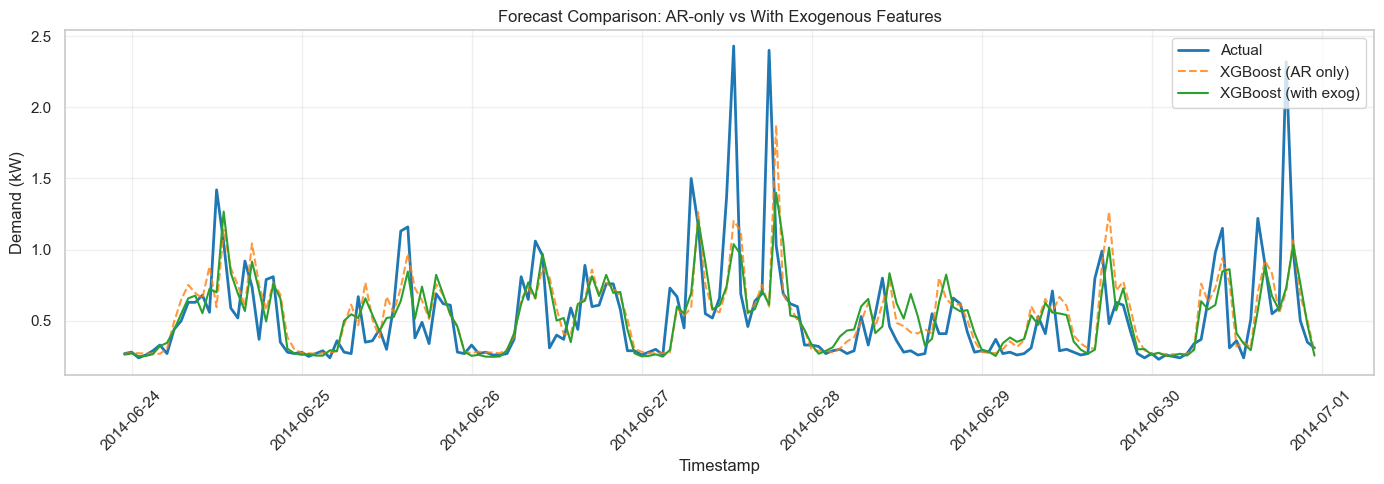

✓ Forecast comparison plot saved


In [12]:
# ─────────────────────────────────────────────────────────────────────────────
# Figure 1: Forecast Comparison
# ─────────────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(test_df["timestamp"], y_test, label="Actual", color="#1f77b4", linewidth=2)
ax.plot(test_df["timestamp"], y_pred_xgb_ar, label="XGBoost (AR only)", 
        color="#ff7f0e", linestyle="--", linewidth=1.5, alpha=0.8)
ax.plot(test_df["timestamp"], y_pred_xgb_full, label="XGBoost (with exog)", 
        color="#2ca02c", linestyle="-", linewidth=1.5)

ax.set_xlabel("Timestamp")
ax.set_ylabel("Demand (kW)")
ax.set_title("Forecast Comparison: AR-only vs With Exogenous Features")
ax.legend(loc="upper right")
ax.grid(alpha=0.3)
ax.tick_params(axis="x", rotation=45)

save_figure(fig, "10_forecast_comparison.png")
print("✓ Forecast comparison plot saved")

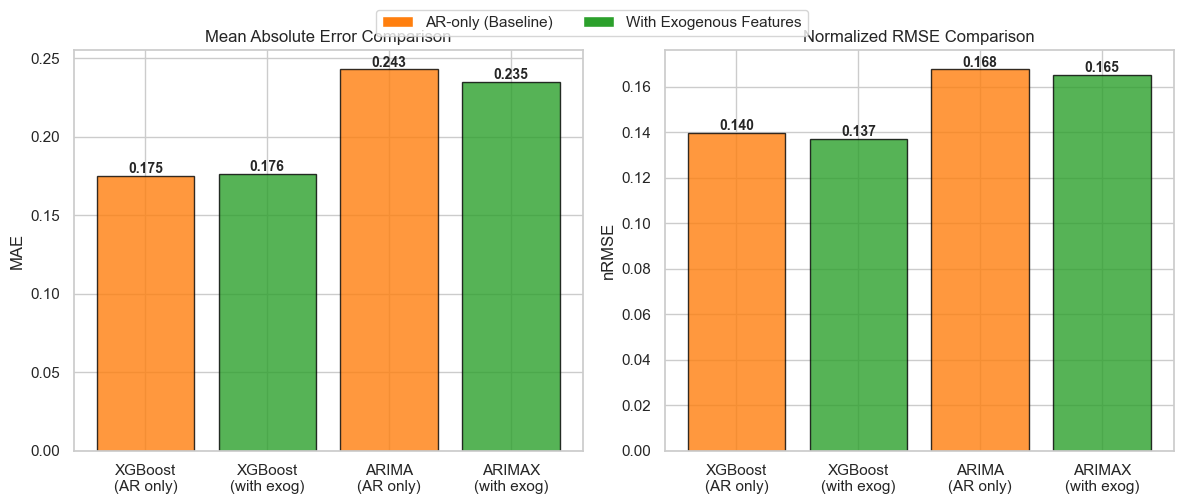

✓ Metrics comparison plot saved


In [13]:
# ─────────────────────────────────────────────────────────────────────────────
# Figure 2: Metrics Comparison Bar Chart
# ─────────────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# MAE comparison
models = ["XGBoost\n(AR only)", "XGBoost\n(with exog)", "ARIMA\n(AR only)", "ARIMAX\n(with exog)"]
mae_values = comparison_df["MAE"].values
colors = ["#ff7f0e", "#2ca02c", "#ff7f0e", "#2ca02c"]

bars1 = axes[0].bar(models, mae_values, color=colors, edgecolor="black", alpha=0.8)
axes[0].set_ylabel("MAE")
axes[0].set_title("Mean Absolute Error Comparison")
for bar, val in zip(bars1, mae_values):
    axes[0].annotate(f"{val:.3f}", xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                     ha="center", va="bottom", fontsize=10, fontweight="bold")

# nRMSE comparison
nrmse_values = comparison_df["nRMSE"].values
bars2 = axes[1].bar(models, nrmse_values, color=colors, edgecolor="black", alpha=0.8)
axes[1].set_ylabel("nRMSE")
axes[1].set_title("Normalized RMSE Comparison")
for bar, val in zip(bars2, nrmse_values):
    axes[1].annotate(f"{val:.3f}", xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                     ha="center", va="bottom", fontsize=10, fontweight="bold")

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor="#ff7f0e", label="AR-only (Baseline)"),
                   Patch(facecolor="#2ca02c", label="With Exogenous Features")]
fig.legend(handles=legend_elements, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.02))

save_figure(fig, "10_metrics_comparison.png")
print("✓ Metrics comparison plot saved")

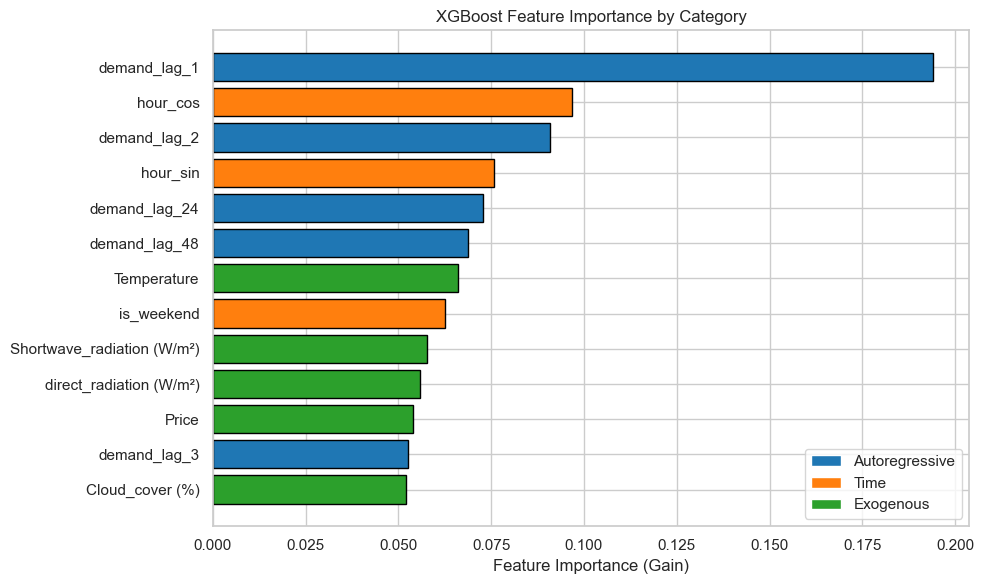

,Feature,Importance,Category
12,Cloud_cover (%),0.052022,Exogenous
2,demand_lag_3,0.052632,Autoregressive
9,Price,0.053897,Exogenous
11,direct_radiation (W/m²),0.055965,Exogenous
10,Shortwave_radiation (W/m²),0.057712,Exogenous
7,is_weekend,0.062454,Time
8,Temperature,0.066124,Exogenous
4,demand_lag_48,0.068862,Autoregressive
3,demand_lag_24,0.072897,Autoregressive
5,hour_sin,0.075717,Time


✓ Feature importance plot saved


In [14]:
# ─────────────────────────────────────────────────────────────────────────────
# Figure 3: Feature Importance (Exogenous XGBoost)
# ─────────────────────────────────────────────────────────────────────────────
importances = xgb_full.feature_importances_
importance_df = pd.DataFrame({
    "Feature": all_features,
    "Importance": importances
}).sort_values("Importance", ascending=True)

# Categorize features
def categorize_feature(f):
    if "demand_lag" in f:
        return "Autoregressive"
    elif f in ["hour_sin", "hour_cos", "is_weekend"]:
        return "Time"
    else:
        return "Exogenous"

importance_df["Category"] = importance_df["Feature"].apply(categorize_feature)

fig, ax = plt.subplots(figsize=(10, 6))
colors = {"Autoregressive": "#1f77b4", "Time": "#ff7f0e", "Exogenous": "#2ca02c"}
bar_colors = [colors[cat] for cat in importance_df["Category"]]

ax.barh(importance_df["Feature"], importance_df["Importance"], color=bar_colors, edgecolor="black")
ax.set_xlabel("Feature Importance (Gain)")
ax.set_title("XGBoost Feature Importance by Category")

# Add legend
legend_elements = [Patch(facecolor=colors[c], label=c) for c in ["Autoregressive", "Time", "Exogenous"]]
ax.legend(handles=legend_elements, loc="lower right")

save_figure(fig, "10_feature_importance.png")
display_table(importance_df, "10_feature_importance.csv")
print("✓ Feature importance plot saved")